# Visualizations

## Packages and Presets

In [1]:
import pandas as pd
import plotnine as pn
from plotnine import scale_y_continuous, scale_x_continuous
from mizani.formatters import percent_format
import numpy as np

from IPython.display import display


In [2]:
# see: https://nanx.me/ggsci/reference/pal_jama.html
jama_colors = [
    "#374E55FF",
    "#eigenval_eigenval_df8F44FF",
    "#00A1D5FF",
    "#B24745FF",
    "#79AF97FF",
    "#6A6599FF",
    "#80796BFF",
]

# see: https://nanx.me/ggsci/reference/pal_aaas.html
aaas_colors = [
    "#3B4992FF",
    "#EE0000FF",
    "#008B45FF",
    "#631879FF",
    "#008280FF",
    "#008280FF",
    "#BB0021FF",
    "#5F559BFF",
    "#A20056FF",
    "#808180FF",
    "#1B1919FF",
]


theme_academic = pn.theme(
    text=pn.element_text(family="monospace"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=8),  # Smaller font for legend items
    legend_title=pn.element_text(size=9),  # Reduce font size for legend title
    panel_background=pn.element_rect(fill="white"),  # Clean white background
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    legend_position="right",
    legend_key_size=8,
    plot_margin=0.02,
    figure_size=(8, 4),  # Set default figure size (width, height in inches)
)

## Subspace Overlaps

/home/janhsc/miniconda3/envs/cf/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


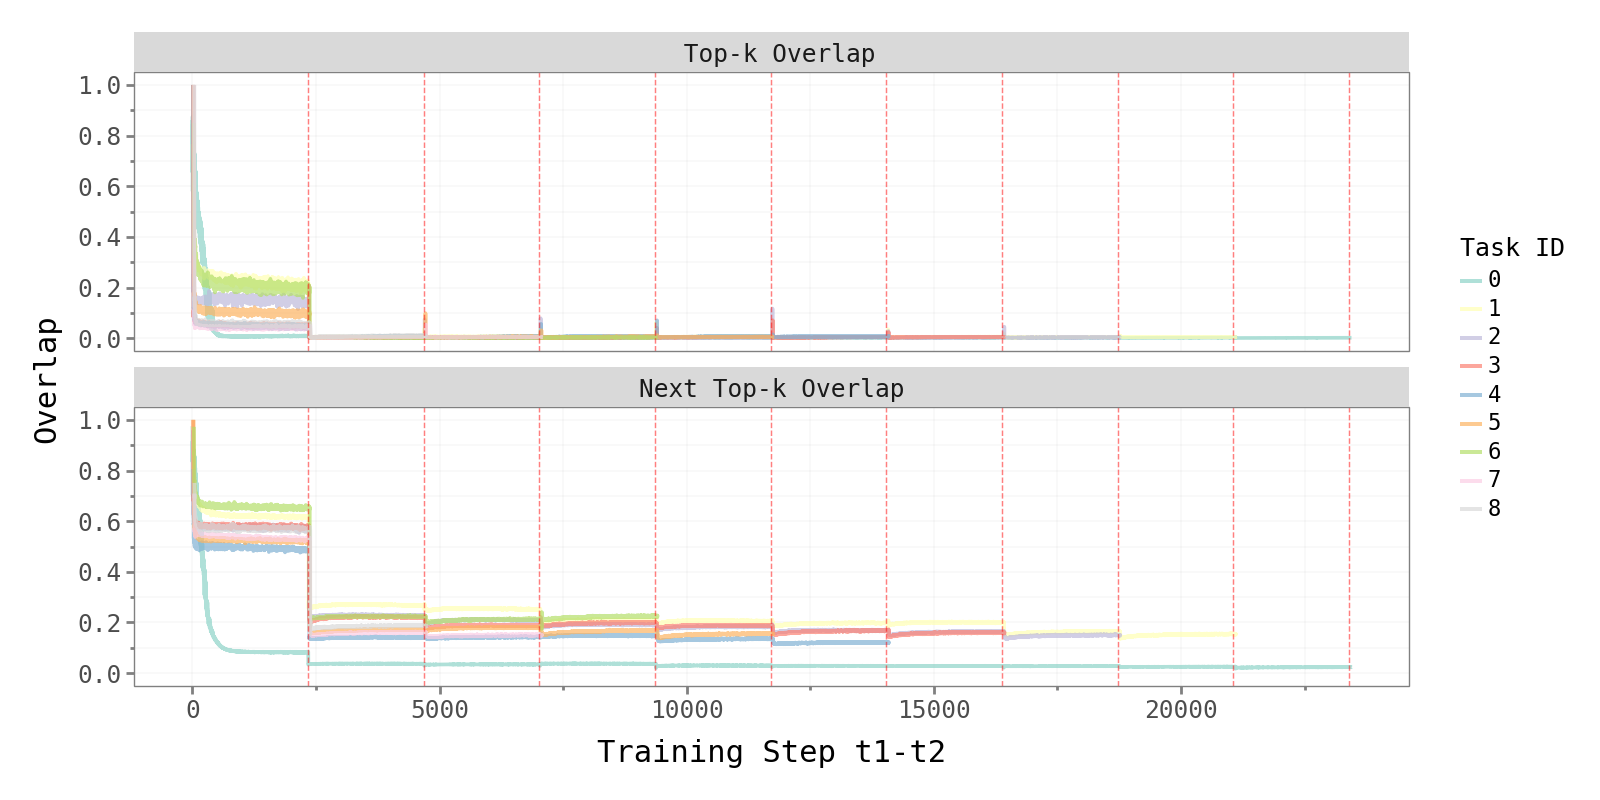

/home/janhsc/miniconda3/envs/cf/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 4 in image.
/home/janhsc/miniconda3/envs/cf/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: overlaps_perm_mnist.pdf
/home/janhsc/miniconda3/envs/cf/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


In [ ]:
overlap_df = pd.read_csv(
    "../results/permuted_mnist/subspace-None/k-10/batch_size-128/hidden_dim-100/lr-0.01/seed-42/metrics/overlaps.csv"
)

steps_per_epoch = 60000 // 128  # nr of batches in dataloader
task_boundaries = np.arange(
    steps_per_epoch * 5, overlap_df["step"].max(), steps_per_epoch * 5
)  # Get every 5th boundary


# reshape  data from wide to long format for faceting
overlap_df_long = pd.melt(
    overlap_df,
    id_vars=["task_id", "step"],
    value_vars=["overlap", "overlap_next_top_k"],
    var_name="metric",
    value_name="value",
)

# Create more descriptive labels for the overlap metrics
overlap_df_long["metric"] = overlap_df_long["metric"].map(
    {"overlap": " Top-k Overlap", "overlap_next_top_k": "Next Top-k Overlap"}
)


fig_overlaps_perm_mnist = (
    pn.ggplot(
        overlap_df_long,
        pn.aes(x="step", y="value", color="factor(task_id)", group="task_id"),
    )
    + pn.geom_line(alpha=0.7, size=0.75)
    + pn.scale_color_brewer(name="Task ID", type="qual", palette="Set3")
    + pn.geom_vline(
        xintercept=task_boundaries, color="red", linetype="dashed", size=0.3, alpha=0.5
    )
    + pn.facet_wrap("~ metric", ncol=1)
    + pn.scale_y_continuous(
        # labels=percent_format(),
        limits=[0, 1],
        breaks=np.arange(0, 1.1, 0.2),
    )
    + theme_academic
    + pn.labs(
        x="Training Step t1-t2",
        y="Overlap",
        # title="Evolution of Top-k Overlaps During Training",
        # caption="Note: Lines represent different training tasks"
    )
)

display(fig_overlaps_perm_mnist)

fig_overlaps_perm_mnist.save("overlaps_perm_mnist.pdf", dpi=300, width=8, height=4)

In [16]:
task_boundaries

array([ 2345,  4690,  7035,  9380, 11725, 14070, 16415, 18760, 21105])

In [19]:
eigenval_df.shape[0] / 20

23450.0

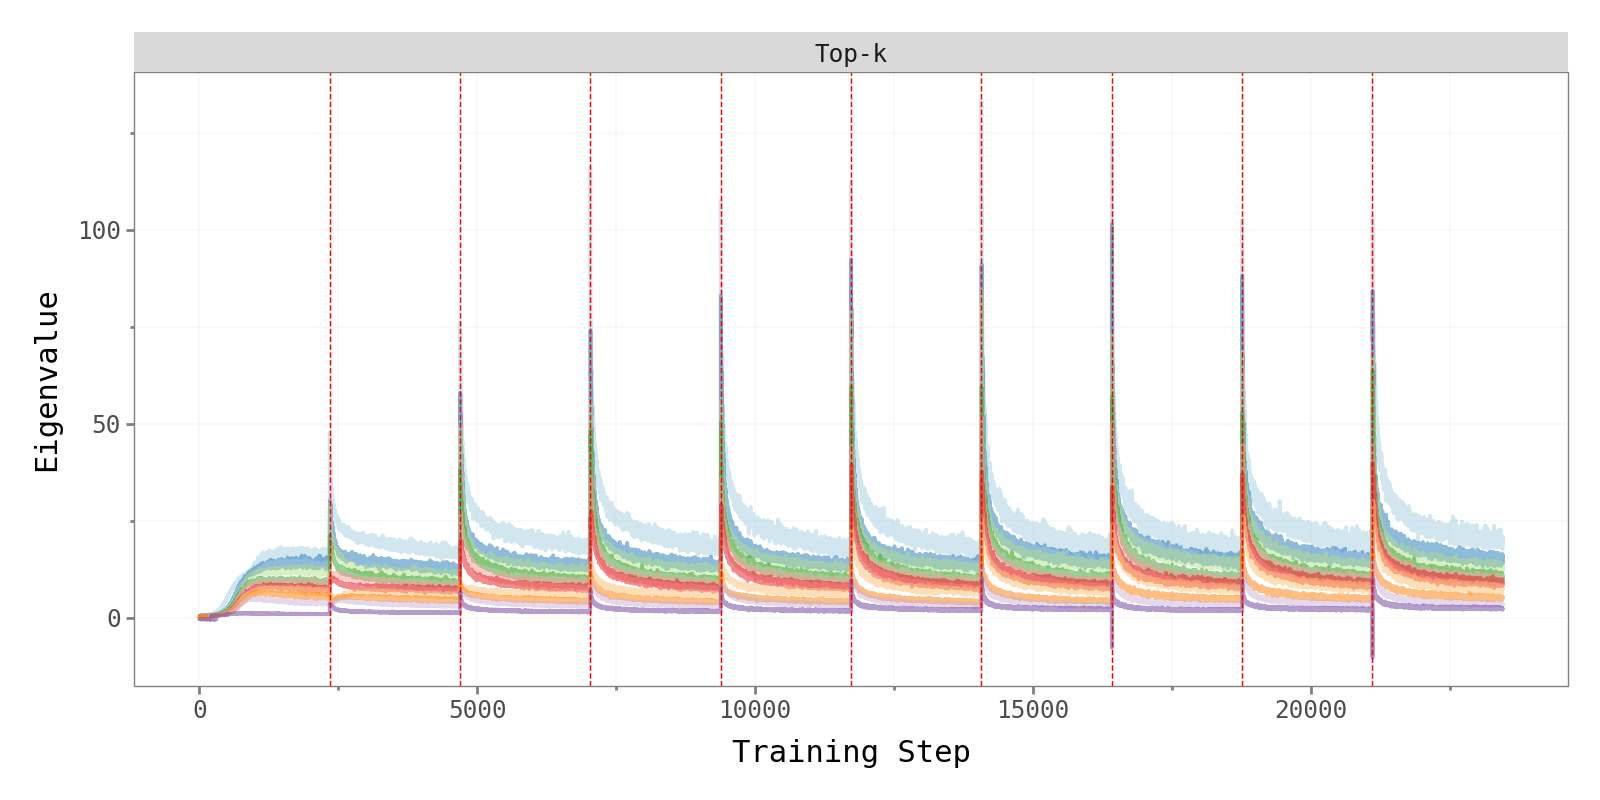

/Users/arminbegic/Coding/cf-tiny-subspaces/cf/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 4 in image.
/Users/arminbegic/Coding/cf-tiny-subspaces/cf/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: eigenvalues_perm_mnist.png


In [158]:
eigenval_df = pd.read_csv(
    "../outputs/pmnist/hd-50_bs-128_lr-0.01/metrics/eigenvalues.csv"
)

# sanity filter for evals between 1 and 20
eigenval_df_filtered = eigenval_df[eigenval_df["eigenvalue_nr"].between(1, 20)].copy()

# distinguish between top 10 and next 10 eigenvalues
eigenval_df_filtered["group"] = "Top-k"  # Default value
eigenval_df_filtered.loc[eigenval_df_filtered["eigenvalue_nr"] > 10, "group"] = (
    "Next Top-k"
)

# calculate step nr
steps_per_epoch = eigenval_df["batch_id"].max() + 1
steps_per_task = steps_per_epoch * 5
eigenval_df_filtered["step"] = (
    # sum of previous tasks:
    eigenval_df_filtered["task_id"] * steps_per_task
    # add steps within task of previous epochs
    + steps_per_epoch * eigenval_df_filtered["epoch"]
    # add steps within epoch
    + eigenval_df_filtered["batch_id"]
    + 1
)

# calc. task boundaries
task_boundaries = np.arange(steps_per_task, 10 * steps_per_task, steps_per_task)

fig_eigenvals_perm_mnist = (
    pn.ggplot(
        eigenval_df_filtered,
        pn.aes(
            x="step",
            y="value",
            color="factor(eigenvalue_nr)",
            group="eigenvalue_nr",
        ),
    )
    + pn.geom_line(size=0.75, alpha=0.5)
    + pn.scale_color_brewer(type="qual", palette="Paired")
    + pn.geom_vline(
        xintercept=task_boundaries, color="red", linetype="dashed", size=0.3
    )
    + pn.facet_wrap("~ group")
    + theme_academic
    + pn.theme(legend_position="none")
    + pn.labs(
        x="Training Step",
        y="Eigenvalue",
        # title="Evolution of Individual Eigenvalues During Training",
    )
)

display(fig_eigenvals_perm_mnist)

fig_eigenvals_perm_mnist.save(
    "eigenvalues_perm_mnist.png", dpi=300, bbox_inches="tight", height=4, width=8
)

# Ablation Study Plots

### MNIST

In [3]:
#############################################################################################
#                                   GET DATA FOR PLOTS                                      #
#############################################################################################

from pathlib import Path
import re
from typing import Dict, List, Tuple

experiment_pattern = re.compile(r'../outputs/pmnist/hd-(\d+)_bs-(\d+)_lr-(\d+\.?\d*)')

def add_step(eigenvalues):

    k = eigenvalues["eigenvalue_nr"].max()

    eigenvalues['step'] = (eigenvalues.index // k) + 1
    
    return eigenvalues

def parse_experiment_params(folder_name: str) -> Dict[str, float]:
        """Extract experimental parameters from folder name.
        
        Args:
            folder_name (str): Name of the experiment folder
            
        Returns:
            Dict containing the parsed parameters
        """

        global experiment_pattern

        match = experiment_pattern.match(folder_name)
        if not match:
            raise ValueError(f"Invalid experiment folder name format: {folder_name}")
            
        return int(match.group(1)), int(match.group(2)), float(match.group(3))

metrics = ['eigenvalues', 'train_metrics', 'test_metrics', 'forgetting_metrics', 'overlaps']
ablation_types = ['hd', 'bs', 'lr']

# Create dictionaries dynamically
ablation_dict = {key: {subkey: {} for subkey in metrics} for key in ablation_types}
original_run = {key: None for key in metrics}

for item in Path('../outputs/pmnist').iterdir():
    if item.is_dir():
        hd, bs, lr = parse_experiment_params(folder_name=str(item))

        metric_dir = item / "metrics"

        if metric_dir.is_dir():
            for csv_file in metric_dir.glob('*.csv'):

                df = pd.read_csv(csv_file)
                metric_name = csv_file.stem

                if metric_name == 'eigenvalues':
                    df = add_step(df)
                elif metric_name == 'train_metrics':
                    df = df.reset_index()
                    df.rename(columns={'index': 'training_step'}, inplace=True)

                df['hd'], df['bs'], df['lr'] = hd, bs, lr
                    
                if (hd == 100 and bs == 128 and lr != 0.01):
                    ablation_dict['lr'][metric_name][lr] = df
                elif (hd != 100 and bs == 128 and lr == 0.01):
                    ablation_dict['hd'][metric_name][hd] = df
                elif (hd == 100 and bs != 128 and lr == 0.01):
                    ablation_dict['bs'][metric_name][bs] = df

for metric in metrics:

    df = pd.read_csv(f'../outputs/pmnist/hd-100_bs-128_lr-0.01/metrics/{metric}.csv')
    df['hd'], df['bs'], df['lr'] = 100, 128, 0.01
    if metric == 'eigenvalues':
        # sanity filter for evals between 1 and 20
        df = df[df["eigenvalue_nr"].between(1, 10)].copy()
        df.reset_index(drop=True, inplace=True)
        df = add_step(df)
    elif metric == 'train_metrics':
        df = df.reset_index()
        df.rename(columns={'index': 'training_step'}, inplace=True)
        
    original_run[metric] = df

#### Eigenvalues

#### Eigenvalues over Time

In [4]:
original_eigenvalues = original_run['eigenvalues']
boundaries = original_eigenvalues["step"].iloc[np.where(np.diff(original_eigenvalues['task_id']) != 0)[0]]

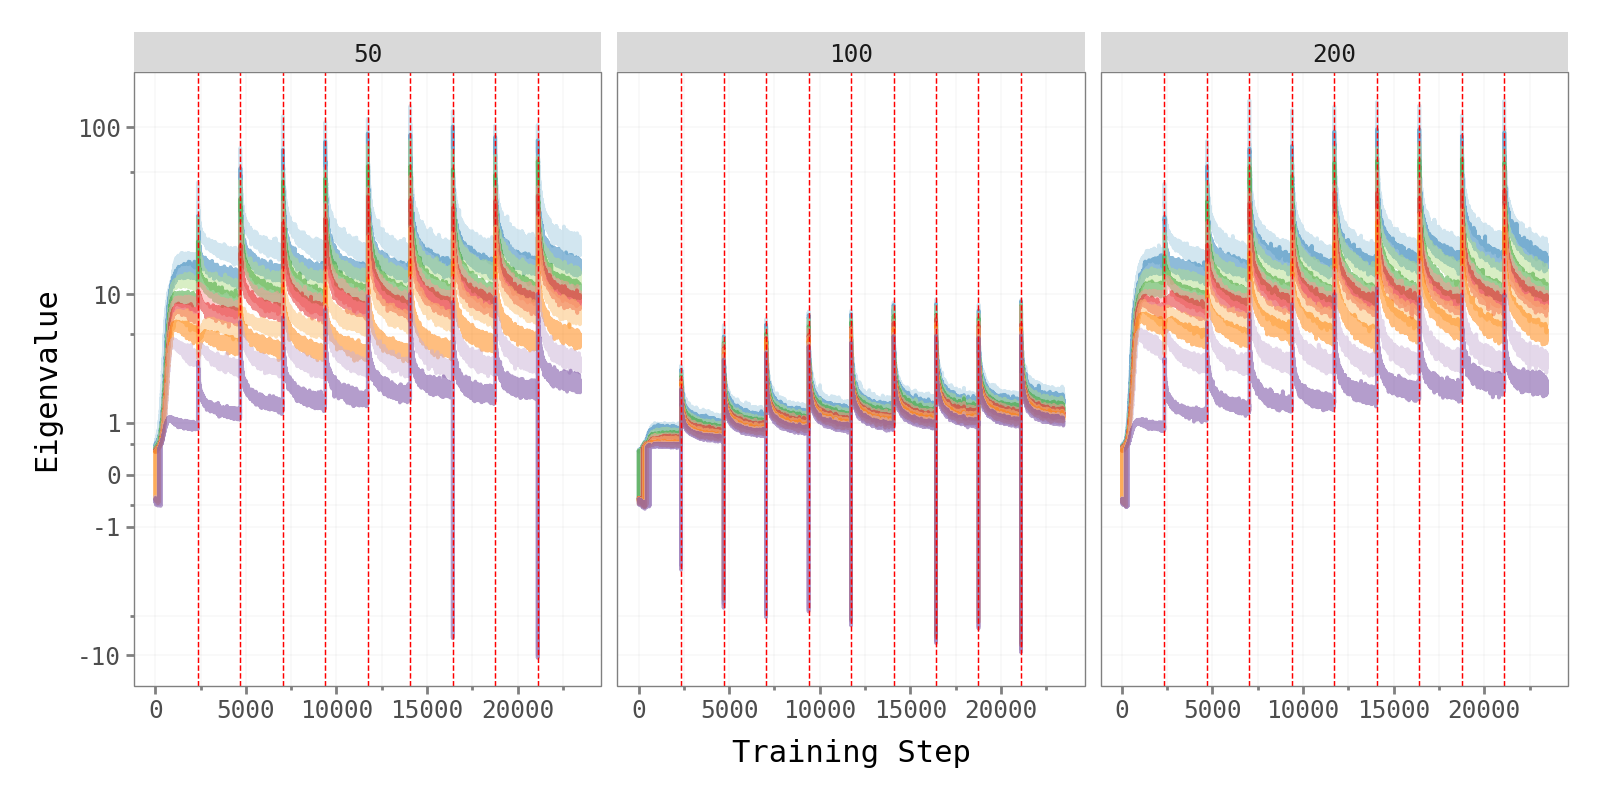

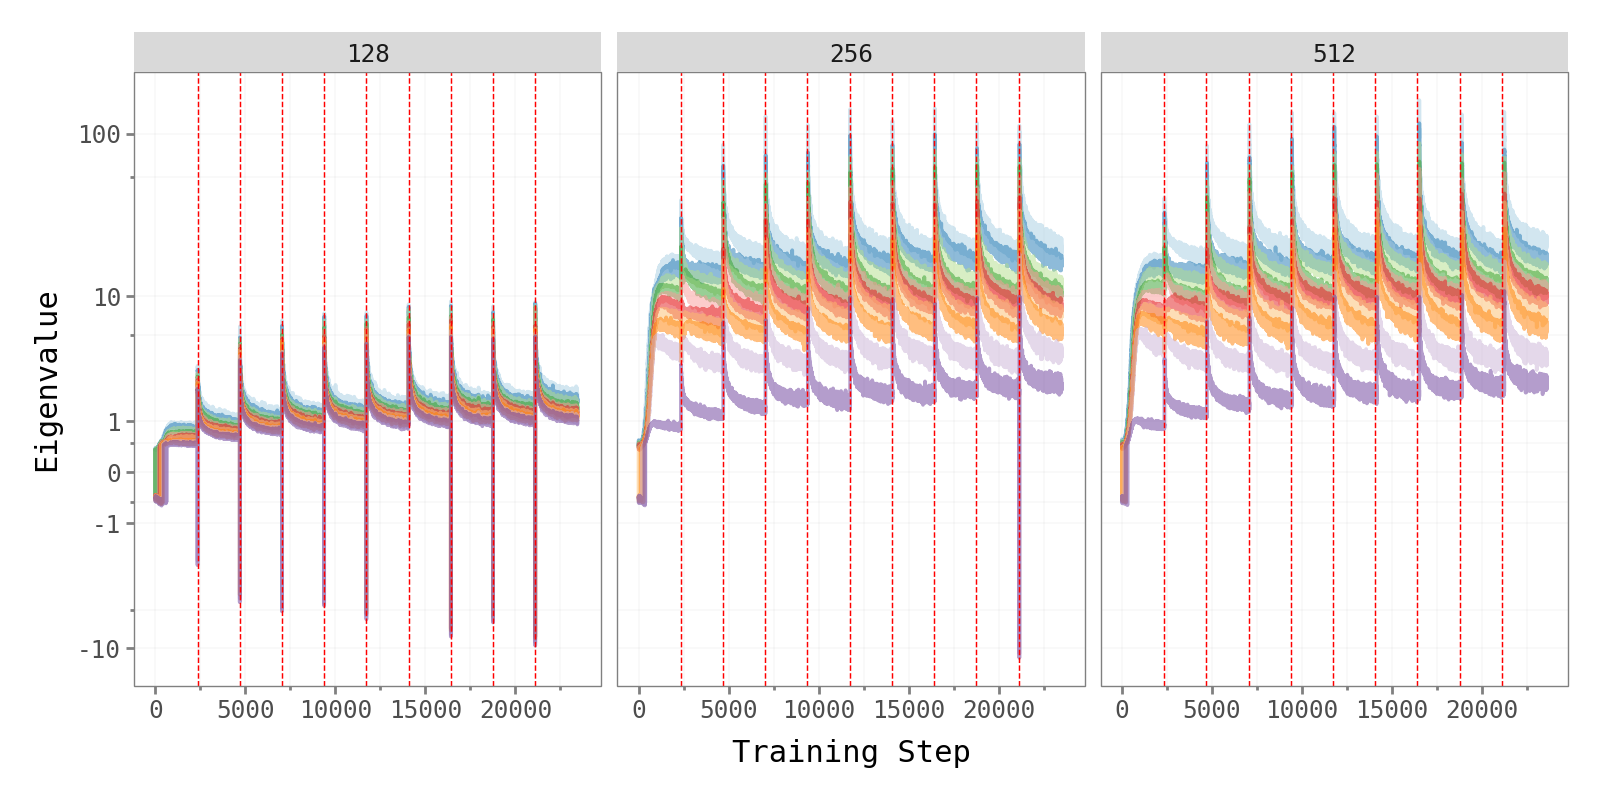

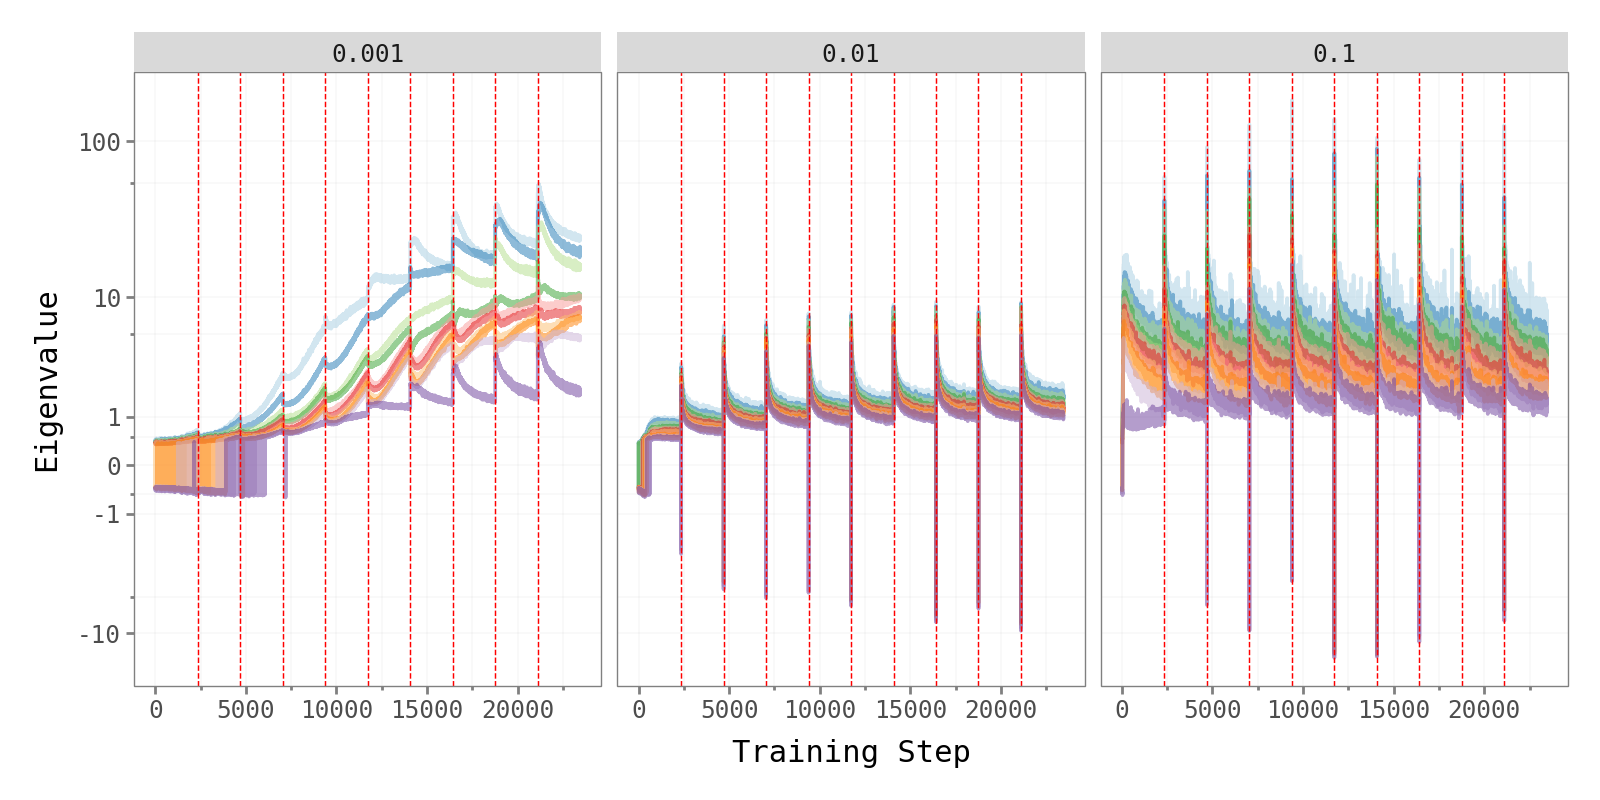

In [12]:
for ab in ablation_dict.keys():

    temp = pd.concat(ablation_dict[ab]['eigenvalues'].values(), ignore_index=True)
    
    fig = (
        pn.ggplot(
            pd.concat([original_eigenvalues, temp], ignore_index=True),
            pn.aes(
                x="step",
                y="value",
                color="factor(eigenvalue_nr)",
                group="eigenvalue_nr",
            ),
        )
        + pn.geom_line(size=0.75, alpha=0.5)
        + pn.scale_color_brewer(type="qual", palette="Paired")
        + pn.geom_vline(
            xintercept=boundaries, color="red", linetype="dashed", size=0.3
        )
        + scale_y_continuous(
                trans='symlog',
                breaks=[-10, -1, 0, 1, 10, 100]
            )
        + pn.facet_wrap(f"~{ab}")
        + theme_academic
        + pn.theme(legend_position="none")
        + pn.labs(
            x="Training Step",
            y="Eigenvalue",
        )
    )

    display(fig)


#### Testing Metrics over Time

In [6]:
original_test_metrics = original_run['test_metrics']

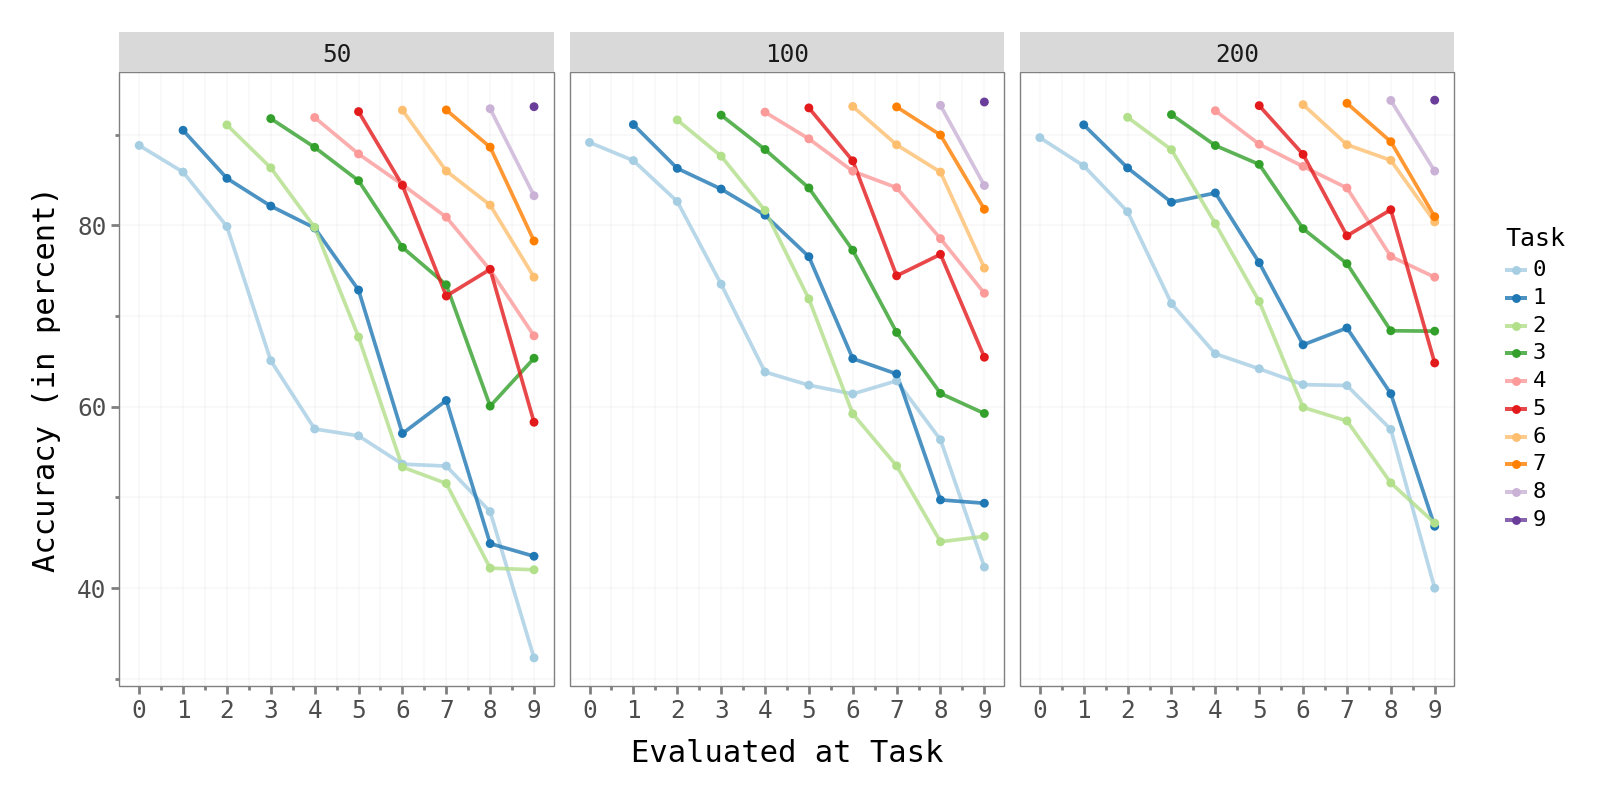

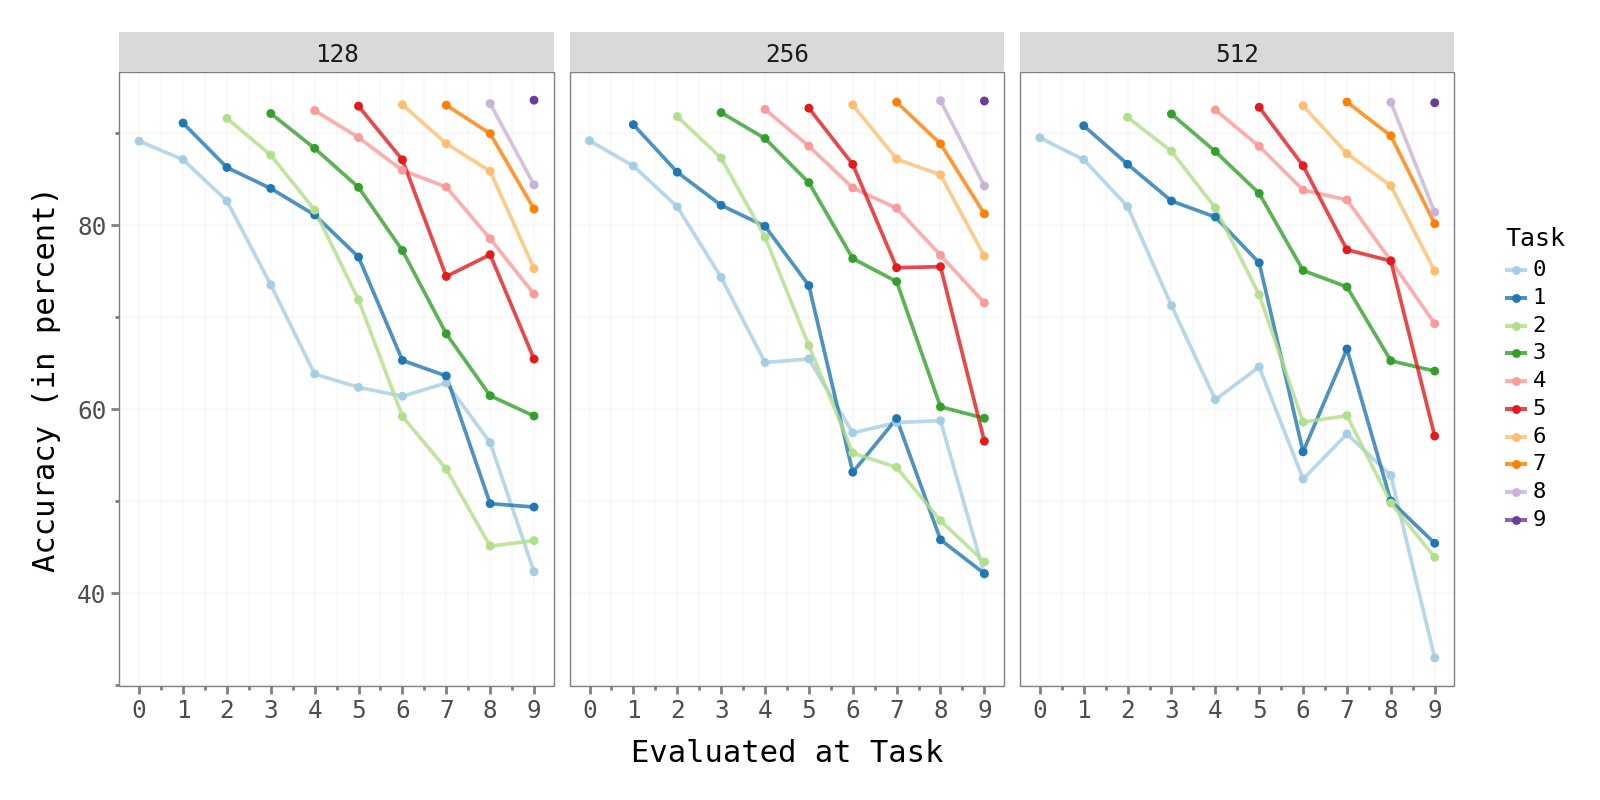

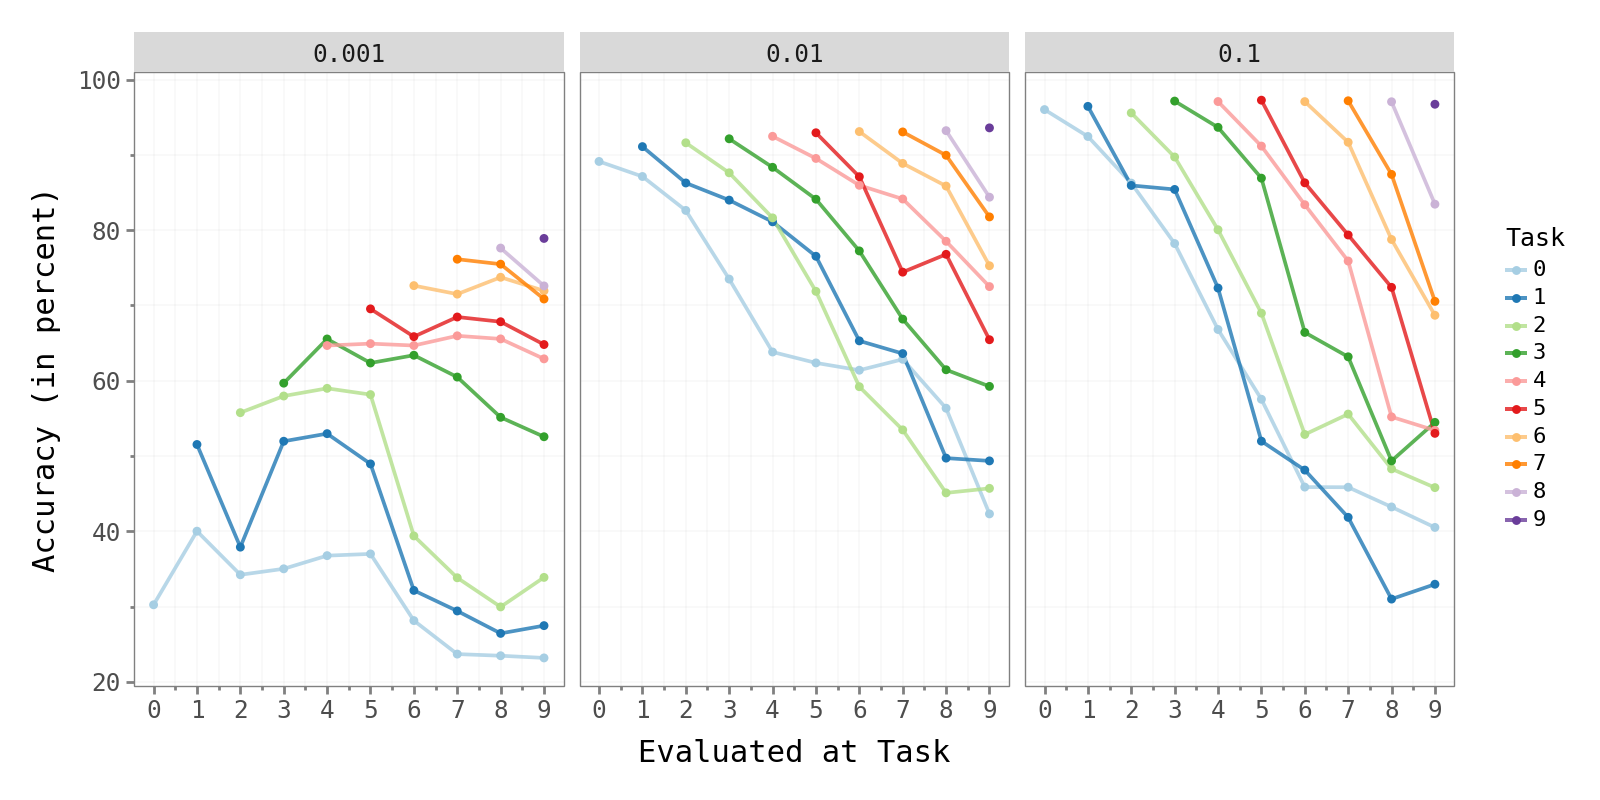

In [22]:
for ab in ablation_dict.keys():

    temp = pd.concat(ablation_dict[ab]['test_metrics'].values(), ignore_index=True)
    
    fig = (
        pn.ggplot(
            pd.concat([original_test_metrics, temp], ignore_index=True),
            pn.aes(
                x="evaluated_at_task",
                y="accuracy",
                color="factor(task_id)",
                group="task_id",
            ),
        )
        + scale_x_continuous(
                breaks=range(original_test_metrics['task_id'].max() + 1),  # Integer breaks
                labels=range(original_test_metrics['task_id'].max() + 1)   # Integer labels
        )
        + pn.geom_line(size=0.75, alpha=0.8)
        + pn.geom_point(size = 0.8)
        + pn.scale_color_brewer(type="qual", palette="Paired")
        + pn.facet_wrap(f"~{ab}")
        + theme_academic
        + pn.labs(
            x="Evaluated at Task",
            y="Accuracy (in percent)",
            color = 'Task'
            # title="Evolution of Individual Eigenvalues During Training",
        )
    )

    display(fig)


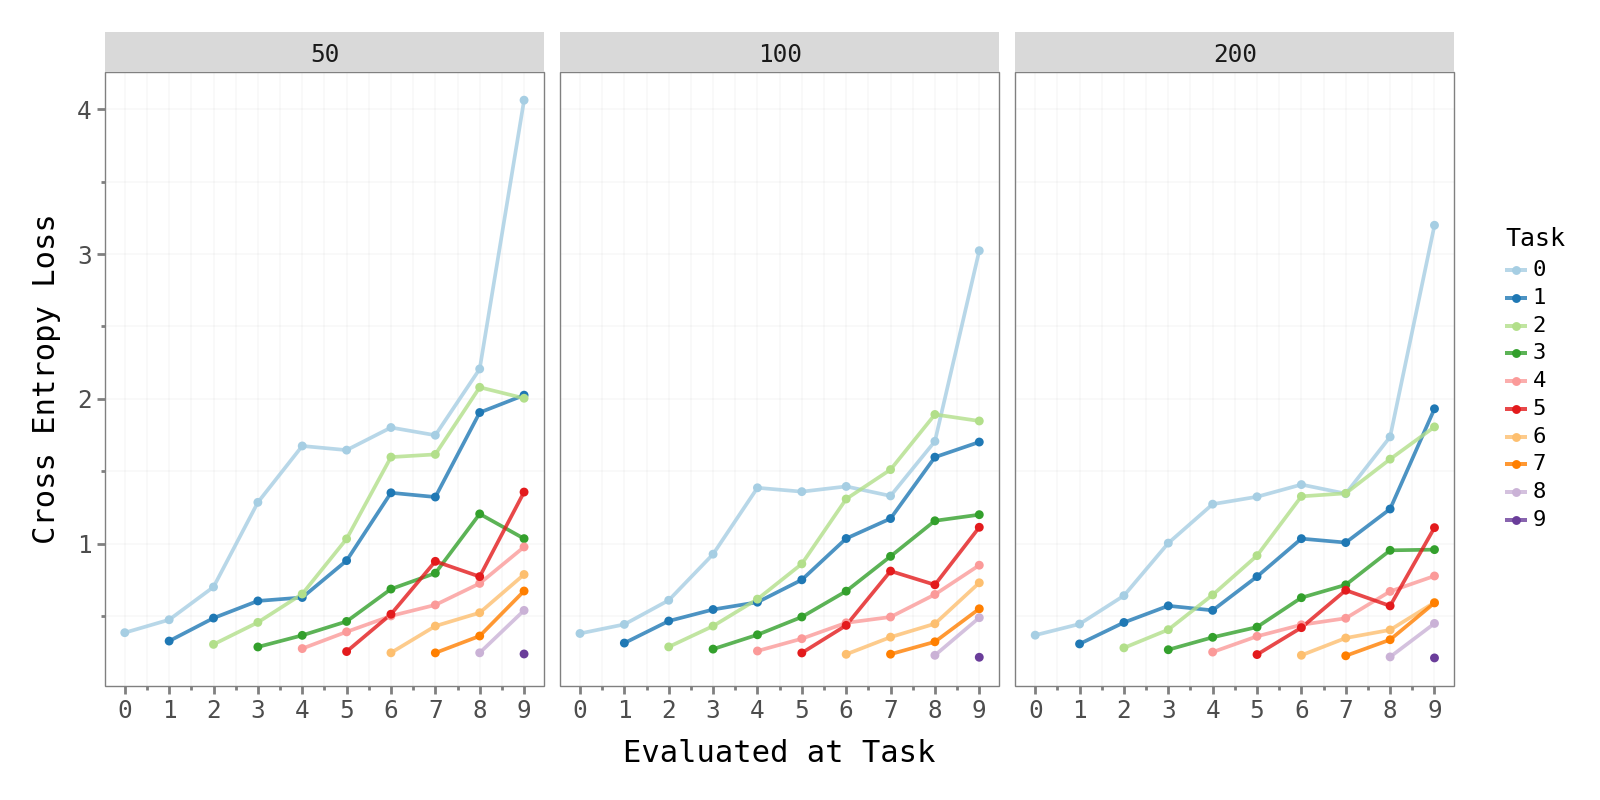

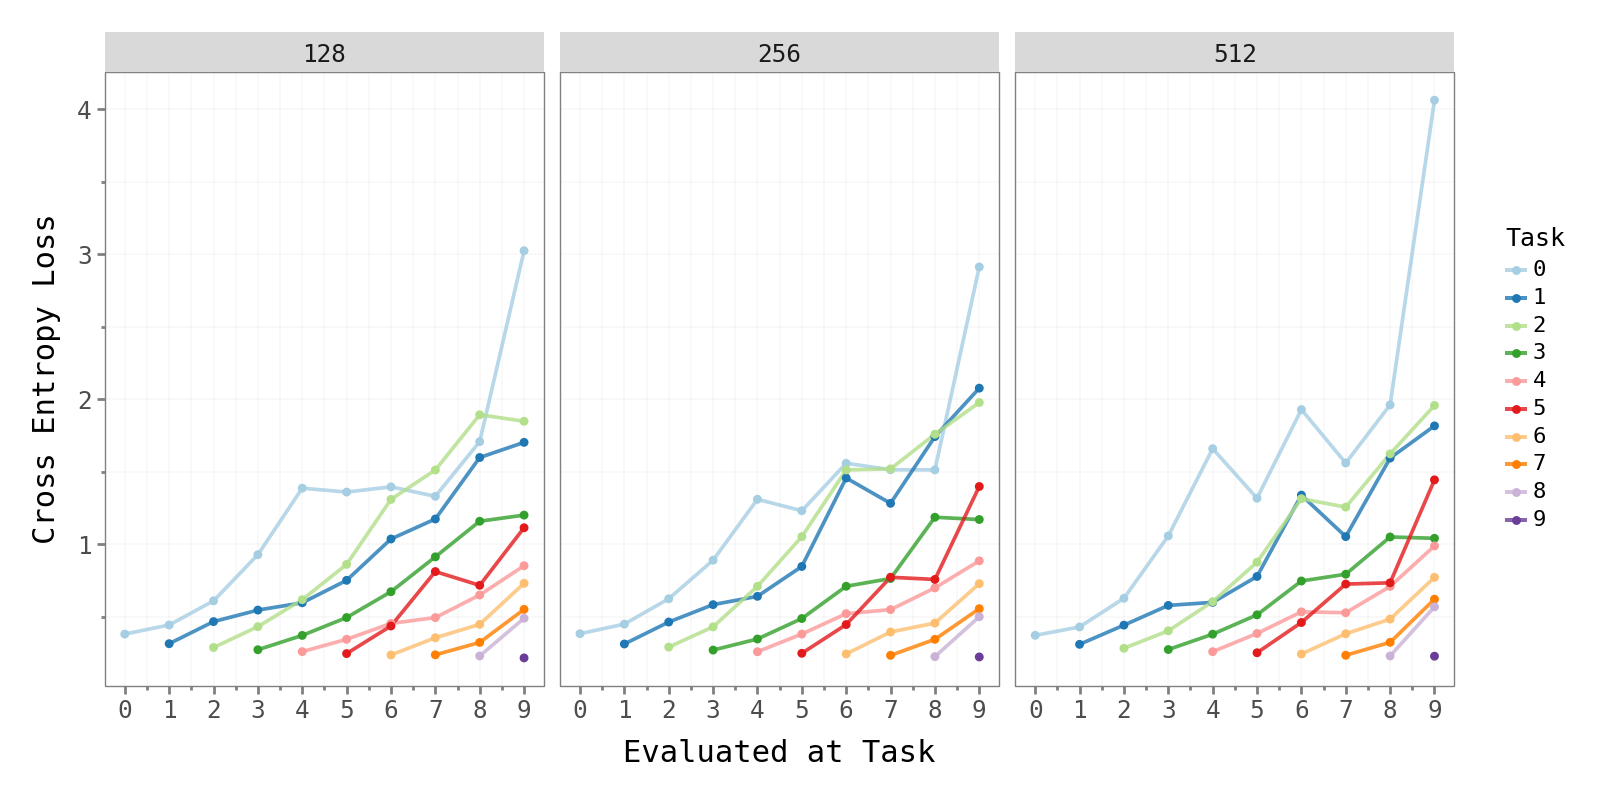

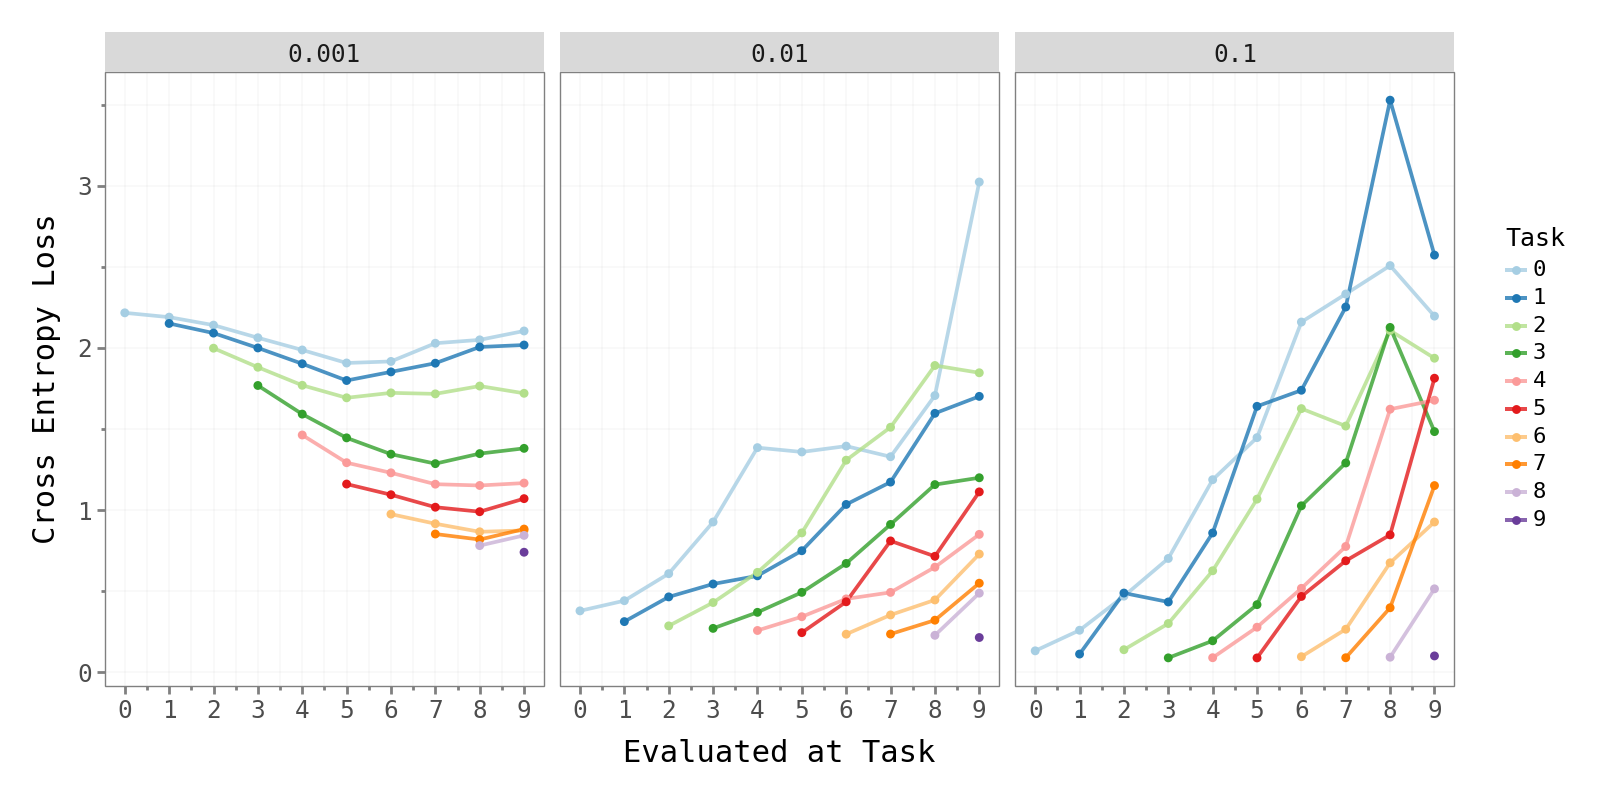

In [23]:
for ab in ablation_dict.keys():

    temp = pd.concat(ablation_dict[ab]['test_metrics'].values(), ignore_index=True)
    
    fig = (
        pn.ggplot(
            pd.concat([original_test_metrics, temp], ignore_index=True),
            pn.aes(
                x="evaluated_at_task",
                y="loss",
                color="factor(task_id)",
                group="task_id",
            ),
        )
        + scale_x_continuous(
                breaks=range(original_test_metrics['task_id'].max() + 1),  # Integer breaks
                labels=range(original_test_metrics['task_id'].max() + 1)   # Integer labels
        )
        + pn.geom_line(size=0.75, alpha=0.8)
        + pn.geom_point(size = 0.8)
        + pn.scale_color_brewer(type="qual", palette="Paired")
        + pn.facet_wrap(f"~{ab}")
        + theme_academic
        + pn.labs(
            x="Evaluated at Task",
            y="Cross Entropy Loss",
            color = "Task"
            # title="Evolution of Individual Eigenvalues During Training",
        )
    )

    display(fig)


#### Training Metrics over Time

In [9]:
original_train_metrics = original_run['train_metrics']

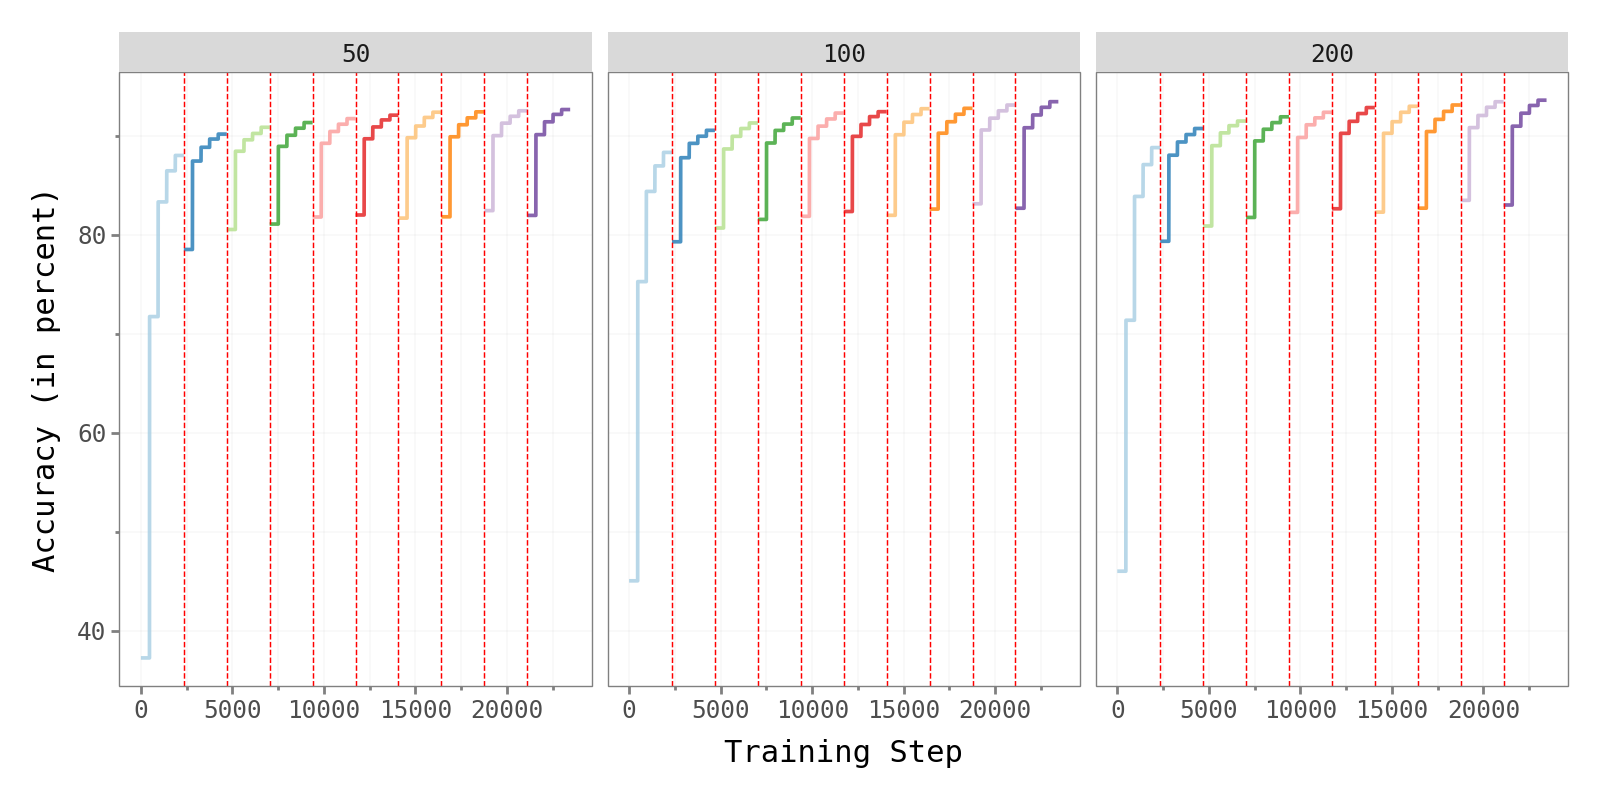

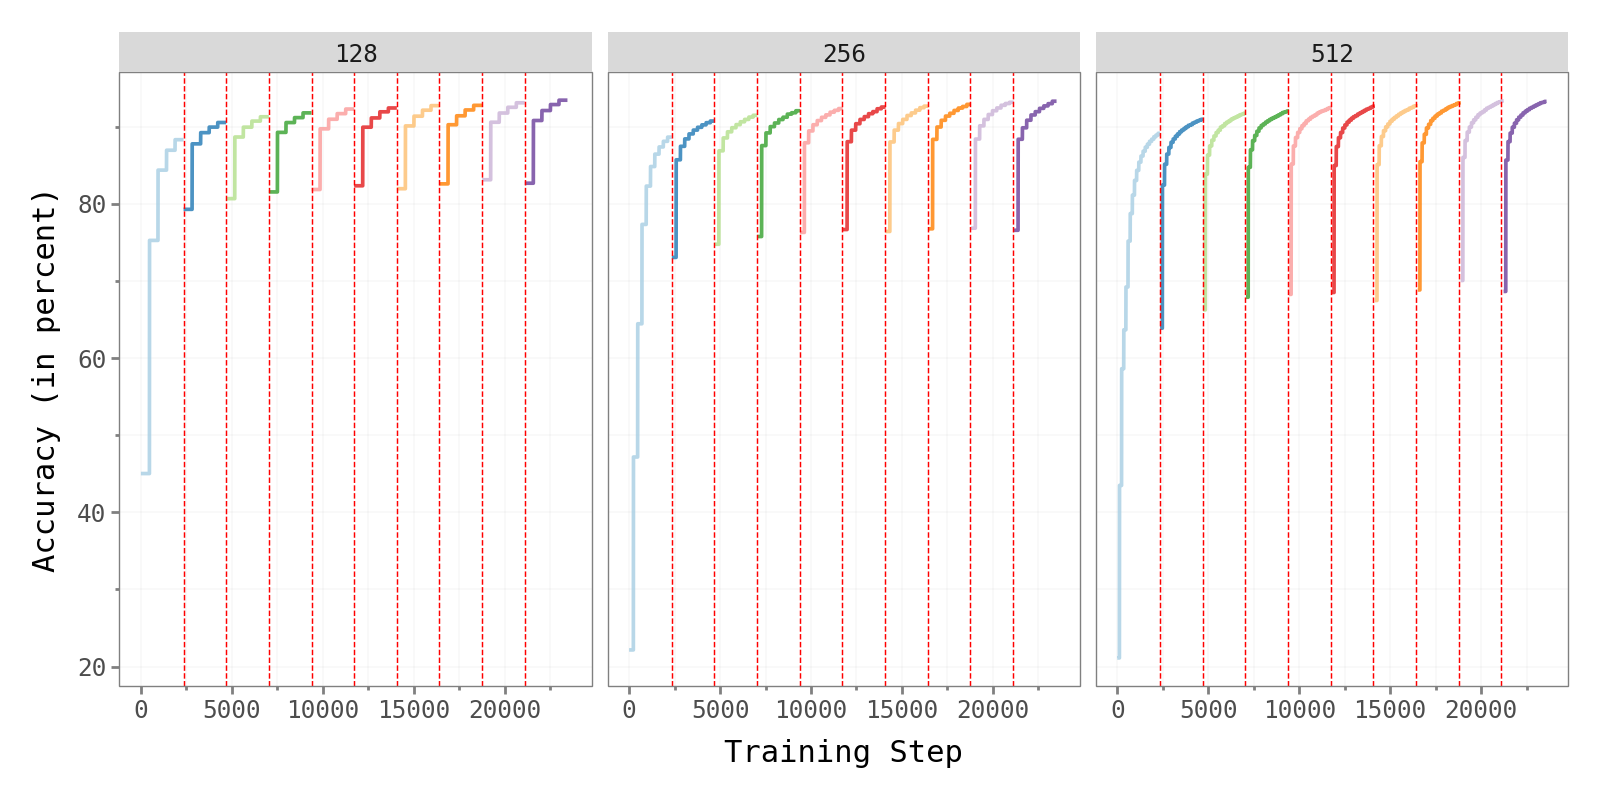

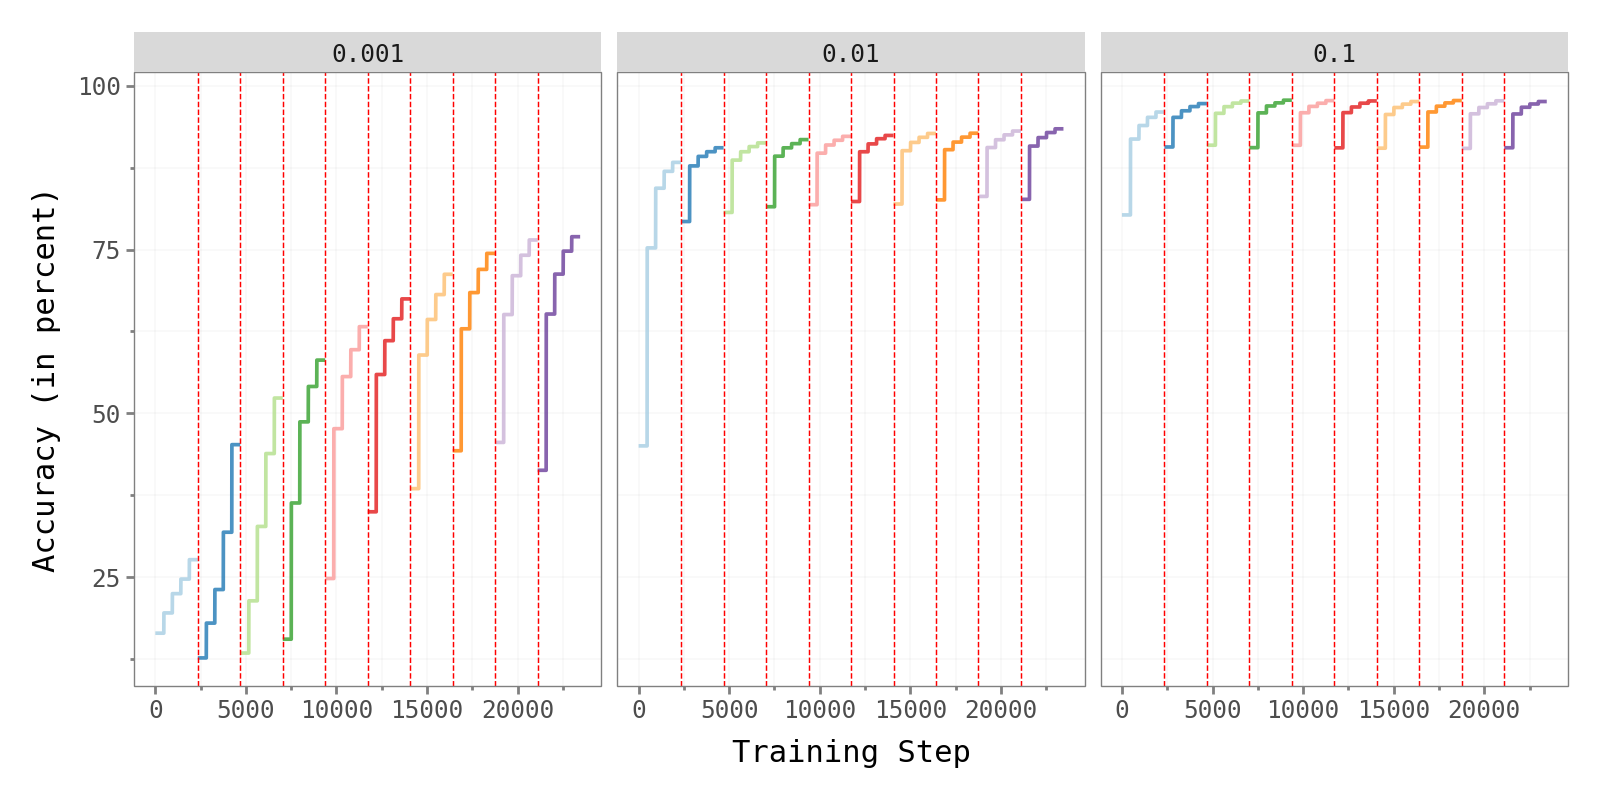

In [19]:
for ab in ablation_dict.keys():

    temp = pd.concat(ablation_dict[ab]['train_metrics'].values(), ignore_index=True)
    
    fig = (
        pn.ggplot(
            pd.concat([original_train_metrics, temp], ignore_index=True),
            pn.aes(
                x="training_step",
                y="accuracy",
                color="factor(task_id)",
                group="task_id",
            ),
        )
        + pn.geom_line(size=0.75, alpha=0.8)
        + pn.scale_color_brewer(type="qual", palette="Paired")
        + pn.geom_vline(
            xintercept=boundaries, color="red", linetype="dashed", size=0.3 # reuse the same as for eigenvalues
        )
        + pn.facet_wrap(f"~{ab}")
        + theme_academic
        + pn.theme(legend_position="none")
        + pn.labs(
            x="Training Step",
            y="Accuracy (in percent)",
        )
    )

    display(fig)


In [ ]:
original_train_metrics = original_run['train_metrics']

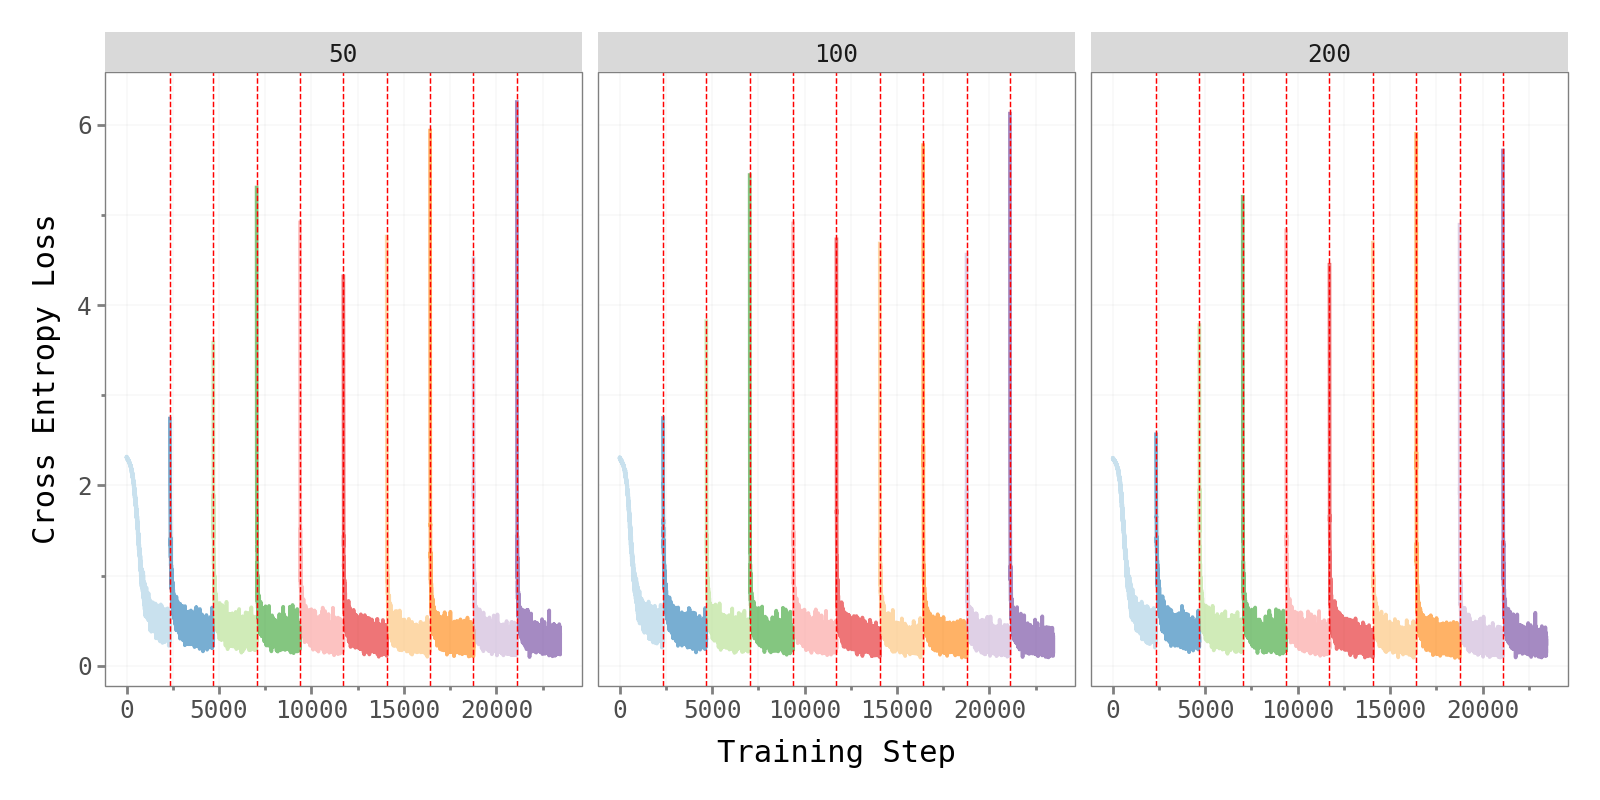

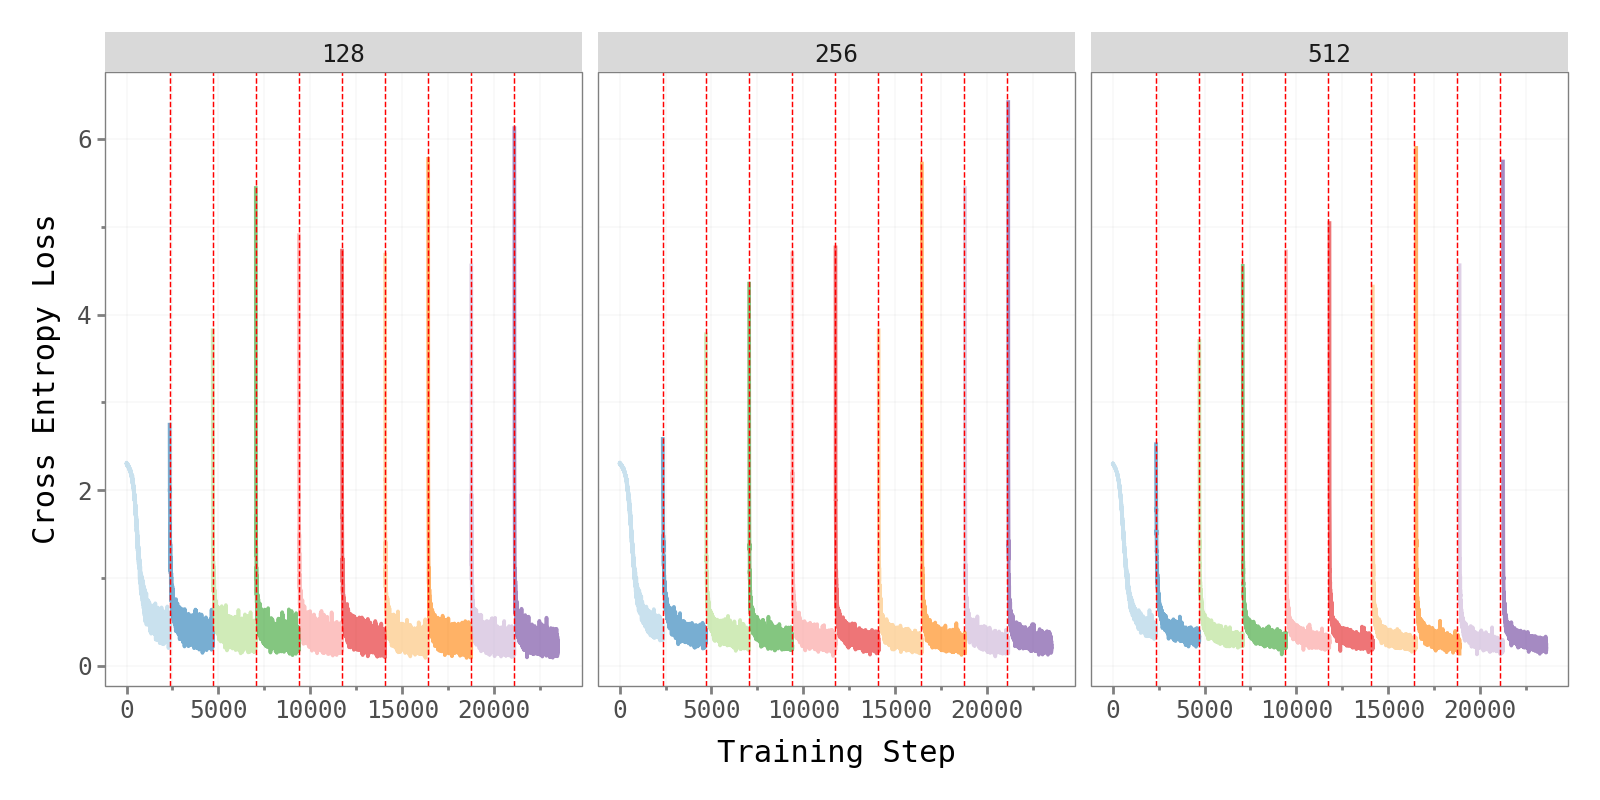

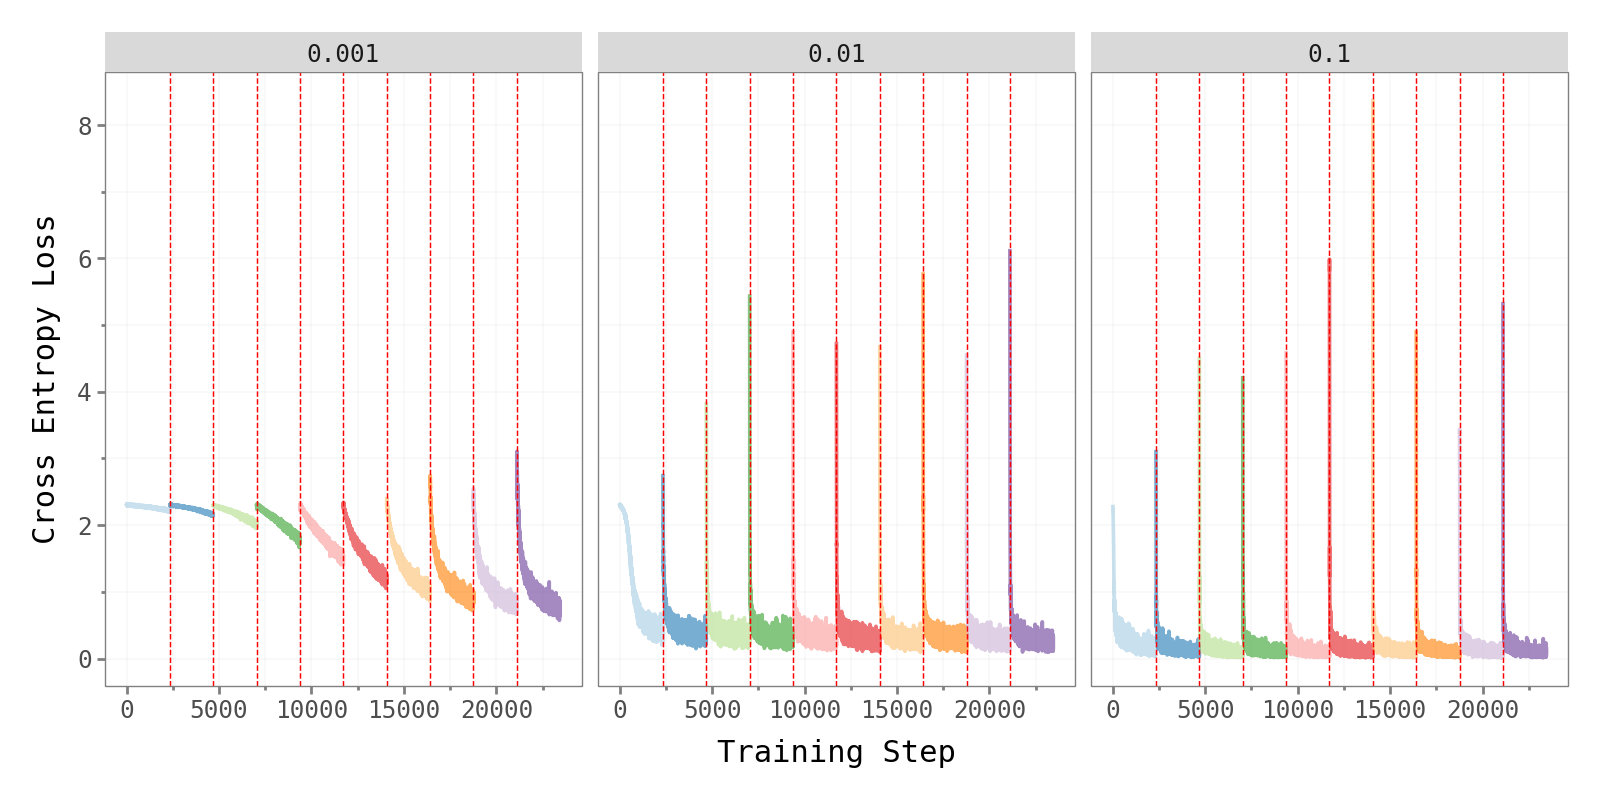

In [15]:
for ab in ablation_dict.keys():

    temp = pd.concat(ablation_dict[ab]['train_metrics'].values(), ignore_index=True)
    
    fig = (
        pn.ggplot(
            pd.concat([original_train_metrics, temp], ignore_index=True),
            pn.aes(
                x="training_step",
                y="loss",
                color="factor(task_id)",
                group="task_id",
            ),
        )
        + pn.geom_line(size=0.75, alpha=0.6)
        + pn.scale_color_brewer(type="qual", palette="Paired")
        + pn.geom_vline(
            xintercept=boundaries, color="red", linetype="dashed", size=0.3 # reuse the same as for eigenvalues
        )
        + pn.facet_wrap(f"~{ab}")
        + theme_academic
        + pn.theme(legend_position="none")
        + pn.labs(
            x="Training Step",
            y="Cross Entropy Loss",
        )
    )

    display(fig)
